In [1]:
#!pip freeze
#!pip uninstall ward-metrics --yes
#!pip install ward-metrics
#!pip install pickle5

In [2]:
%pylab inline
import pickle5 as pickle
import glob
import os
import pandas as pd
import numpy as np
import sys

sys.path.insert(0, ".")

import seaborn as sns

sns.set()
sns.set_style("whitegrid")
sns.set_context("paper")


def pd_full(rows=100):
    pd.set_option("display.max_rows", rows)
    pd.set_option("display.max_columns", None)
    pd.set_option("display.width", 2000)
    pd.set_option("display.float_format", "{:20,.3f}".format)
    pd.set_option("display.max_colwidth", 20)


pd_full()

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Load relevant experiment script
import scripts.run_base_configs_exp as exp
from filternet.training.evalmodel import *

In [4]:
from filternet.datasets.opportunity import get_x_y_contig
from filternet.datasets import sliding_window_x_y
from filternet.training.train import FilternetDataset, TrnsDt, TrnsDt_Trgt
from torch.utils.data import DataLoader, TensorDataset

# REPLACE WITH NEW MODEL
model_dir = './scripts/saved_models/base_configs_7_multi_scale_cnn_lstm_1'
em = load_eval_model_from_dir(model_dir)
# em.run_test_set()
# em.calc_metrics()
# em.calc_ward_metrics()

display(em.classification_report_df)
em.f1, em.f1_mean, em.infer_samples_per_s, em.n_samples_in, em.n_samples_out


,precision,recall,f1-score,support,event_f1
,0.963,0.959,0.961,12337,0.922
Open Door 1,0.621,0.857,0.720,84,0.667
Open Door 2,0.930,0.833,0.879,144,0.933
Close Door 1,0.728,0.670,0.698,88,0.714
Close Door 2,0.827,0.992,0.902,125,0.889
Open Fridge,0.872,0.660,0.751,341,0.931
Close Fridge,0.787,0.907,0.843,236,0.982
Open Dishwasher,0.659,0.738,0.696,149,0.727
Close Dishwasher,0.671,0.831,0.742,118,0.737
Open Drawer 1,0.683,0.695,0.689,59,0.632


(0.9260763034888204, 0.7455457850458616, 58715.49246745205, 57856, 14816)

In [5]:
Xc, ycs, data_spec = get_x_y_contig('test')
dls = {}
win_lens = [
    32, 
    64, 
    128, 
    256, 
    512, 
    1024, 
    1024*2, 
    1024*4, 
    1024* 8, 
    1024*16
]

new_len = int(floor(len(Xc) / np.max(win_lens)) * np.max(win_lens))
print(f'Cropping data from {len(Xc)} to {new_len} for consistency between win_lens')
Xc = Xc[:new_len]
ycs = [yc[:new_len] for yc in ycs]

'''
for win_len in win_lens:
    print(win_len)
    # Properly window data for this model
    X, ys = sliding_window_x_y(
        Xc,
        ycs,
        win_len=win_len,
        step=int(win_len/2),
        shuffle=False,  
    )

    dls[win_len] = DataLoader(
        TensorDataset(torch.Tensor(X), *[torch.Tensor(y).long() for y in ys]),
        batch_size=em.eval_batch_size,
        shuffle=False,
    )
'''
for win_len in win_lens:
    print(win_len)
    ds = FilternetDataset(Xc, ycs, win_len=win_len, step=int(win_len / 2),
                          transform = TrnsDt(), target_transform = TrnsDt_Trgt())
    dls[win_len] = DataLoader(ds,
            batch_size=em.eval_batch_size,
            shuffle=False)


Loading cached data.
Loaded.
Cropping data from 118750 to 114688 for consistency between win_lens
32
64
128
256
512
1024
2048
4096
8192
16384


In [6]:
results = []

In [7]:

for base_config in ['base_cnn', 'multi_scale_cnn','base_lstm',
       'cnn_lstm',  
                    'multi_scale_cnn_lstm']:
    for i_run in range(2,7):
        model_dir = f'./scripts/saved_models/base_configs_7_{base_config}_{i_run}'
        print(model_dir)
        em = load_eval_model_from_dir(model_dir)
        
        for win_len in win_lens:
            print(win_len)

            em.cuda = True
            em.device = 'cuda'
            em.model.cuda()
            em.run_test_set(dls[win_len])
            cuda_infer_rate = em.infer_samples_per_s

            em.cuda = False
            em.device = 'cpu'
            em.model.cpu()
            em.run_test_set(dls[win_len])
            cpu_infer_rate = em.infer_samples_per_s

            # Run on this data subset
            em.run_test_set(dls[win_len])
            # Calc new metrics for *just* this subset
            em.calc_metrics()
            em.calc_ward_metrics()

        #     display(em.classification_report_df)
            print(em.f1, em.f1_mean, em.event_f1, int(em.infer_samples_per_s/1000), em.n_samples_in, em.n_samples_out)
            results.append(dict(
                win_len=win_len,
                i_run=i_run,
                model_dir=model_dir,
                base_config=em.trainer.base_config,
                f1=em.f1, 
             f1_mean=em.f1_mean,
             event_f1=em.event_f1,
#              fer_samples_per_s=em.infer_samples_per_s,
             cuda_infer_rate = cuda_infer_rate,
             cpu_infer_rate  = cpu_infer_rate
            ))


./scripts/saved_models/base_configs_7_base_cnn_2
32


C:\Users\afsamani\Anaconda3\envs\filternet\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\afsamani\Anaconda3\envs\filternet\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


0.8959668193216571 0.6224765698020036 0.6345212290248746 2 3616 14336
64
0.8985128328098583 0.6331993286901787 0.6542230676472086 5 7232 14336
128
0.898457891409716 0.6337271184340116 0.6573941569799068 11 14464 14336
256
0.898489133079215 0.6335200100580666 0.6573484823243262 24 28928 14336
512
0.8984263050739083 0.6334287479273263 0.6563589031297565 47 57856 14336
1024
0.8984263050739083 0.6334287479273263 0.6563589031297565 98 115712 14336
2048
0.8984263050739083 0.6334287479273263 0.6563589031297565 176 231424 14336
4096
0.8984263050739083 0.6334287479273263 0.6563589031297565 394 462848 14336
8192
0.8984263050739083 0.6334287479273263 0.6563589031297565 813 925696 14336
16384
0.8984263050739083 0.6334287479273263 0.6563589031297565 1750 1851392 14336
./scripts/saved_models/base_configs_7_base_cnn_3
32
0.8957630176152402 0.6184143028632215 0.5850472134789854 2 3616 14336
64
0.8973805672647359 0.6189356330732794 0.6038667771782338 5 7232 14336
128
0.8975521290345095 0.62075094974015

C:\Users\afsamani\Anaconda3\envs\filternet\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.8535846072403077 0.3876784589894652 0.5259261714563515 2 3616 14336
64
0.8826469486962798 0.5608045363227757 0.6190079199666527 5 7232 14336
128
0.9101123780861692 0.6780585741378462 0.7551977598879943 10 14464 14336
256
0.912495720856631 0.6825364089389169 0.7576707784803567 23 28928 14336
512
0.9112624203031287 0.6762369613806313 0.7591264021562487 42 57856 14336
1024
0.9109853447238583 0.6748986061709545 0.7565586217730533 87 115712 14336
2048
0.9110116283034103 0.675478893860192 0.7593335670783175 166 231424 14336
4096
0.9110116283034103 0.675478893860192 0.7593335670783175 375 462848 14336
8192
0.9110116283034103 0.675478893860192 0.7593335670783175 852 925696 14336
16384
0.9110116283034103 0.675478893860192 0.7593335670783175 1730 1851392 14336
./scripts/saved_models/base_configs_7_multi_scale_cnn_3
32
0.8640783116090465 0.4537412544220125 0.5515789094770566 1 3616 14336
64
0.8971134817765195 0.5899526251830755 0.6342038091498134 5 7232 14336
128
0.9195411038641674 0.6997398945

0.867758537848543 0.4533241434313858 0.5216520210896309 1 3616 14336
64
0.896058925380669 0.5972086879005575 0.6534223310557288 4 7232 14336
128
0.9173555802857299 0.7026852943518174 0.8057111742997156 8 14464 14336
256
0.9234746456051797 0.7146230515920924 0.8380179054757445 18 28928 14336
512
0.9230839997190777 0.7127590235957703 0.8365024032113242 36 57856 14336
1024
0.9246047456138927 0.7193503679039869 0.8480150832722322 76 115712 14336
2048
0.9243222045037255 0.7190721058947229 0.8519414921603705 145 231424 14336
4096
0.9241939796003489 0.7186800469891425 0.8519414921603705 306 462848 14336
8192
0.9242571929183123 0.7187283076244 0.8519414921603705 596 925696 14336
16384
0.9242571929183123 0.7187283076244 0.8519414921603705 1097 1851392 14336
./scripts/saved_models/base_configs_7_cnn_lstm_3
32
0.8699145608053753 0.4770727695872698 0.5146353166986565 1 3616 14336
64
0.8962521213373238 0.6073577953506439 0.6424682395644282 4 7232 14336
128
0.9145632586951719 0.6880947845285976 0.75

In [8]:
'a' # 4204

'a'

In [9]:
df_results = pd.DataFrame(results)
df_results

,win_len,i_run,model_dir,base_config,f1,f1_mean,event_f1,cuda_infer_rate,cpu_infer_rate
0,32,2,./scripts/saved_...,base_cnn,0.896,0.622,0.635,"2,739.683","2,549.662"
1,64,2,./scripts/saved_...,base_cnn,0.899,0.633,0.654,"27,704.513","5,877.107"
2,128,2,./scripts/saved_...,base_cnn,0.898,0.634,0.657,"77,673.532","11,532.767"
3,256,2,./scripts/saved_...,base_cnn,0.898,0.634,0.657,"179,204.520","25,068.640"
4,512,2,./scripts/saved_...,base_cnn,0.898,0.633,0.656,"438,520.630","49,775.470"
...,...,...,...,...,...,...,...,...,...
245,1024,6,./scripts/saved_...,multi_scale_cnn_...,0.921,0.723,0.814,"714,761.349","71,265.651"
246,2048,6,./scripts/saved_...,multi_scale_cnn_...,0.921,0.722,0.810,"1,190,913.970","143,085.616"
247,4096,6,./scripts/saved_...,multi_scale_cnn_...,0.921,0.722,0.810,"2,368,650.265","318,019.524"
248,8192,6,./scripts/saved_...,multi_scale_cnn_...,0.921,0.722,0.810,"4,595,726.259","586,406.225"


In [10]:
df_results.groupby(['base_config', 'win_len']).mean().sort_index().drop('i_run', axis=1)

f1              f1_mean             event_f1      cuda_infer_rate       cpu_infer_rate
base_config          win_len                                                                                                         
base_cnn             32                     0.894                0.610                0.606            7,548.599            2,526.071
                     64                     0.896                0.618                0.632           27,634.080            5,942.745
                     128                    0.897                0.619                0.632           77,937.098           11,498.340
                     256                    0.897                0.619                0.632          184,315.476           24,422.995
                     512                    0.897                0.619                0.632          443,491.326           48,637.892
                     1024                   0.897                0.619                0.632          983,162.752           93,329.338
                     2048                   0.897                0.619                0.632        1,206,946.631          175,880.117
                     4096                   0.897                0.619                0.632        2,884,634.202          416,860.449
                     8192                   0.897                0.619                0.632        6,029,094.867          875,253.231
                     16384                  0.897                0.619                0.632       12,532,241.325        1,829,077.225
base_lstm            32                     0.868                0.493                0.522            6,879.683            1,496.140
                     64                     0.881                0.549                0.537           18,828.185            2,907.803
                     128                    0.888                0.581                0.549           45,600.617            5,601.720
                     256                    0.888                0.581                0.559           96,439.713            9,186.020
                     512                    0.887                0.575                0.553          197,732.384           11,617.242
                     1024                   0.887                0.571                0.552          379,261.135           17,867.290
                     2048                   0.887                0.572                0.551          691,807.695           33,930.087
                     4096                   0.887                0.572                0.551        1,127,043.459          145,646.624
                     8192                   0.887                0.571                0.551        1,690,485.846          241,647.833
                     16384                  0.887                0.572                0.551        4,277,779.298          351,886.645
cnn_lstm             32                     0.870                0.474                0.527            7,414.252            1,842.321
                     64                     0.895                0.595                0.640           22,438.355            4,392.748
                     128                    0.915                0.691                0.771           61,425.587            8,778.622
                     256                    0.920                0.711                0.815          148,532.018           18,614.733
                     512                    0.921                0.706                0.823          344,200.451           37,922.556
                     1024                   0.921                0.701                0.821          749,305.540           73,579.132
                     2048                   0.920                0.700                0.823        1,255,319.008          145,606.000
                     4096                   0.920                0.700                0.823        2,420,202.766          322,971.900
                     8192  

In [11]:
# CHECKPOINT
import time
timestr = time.strftime("%Y%m%d-%H%M%S")
fn =  f"./scripts/saved_models/win_len_timings_df_{timestr}.pkl"
df_results.to_pickle(fn)
fn

'./scripts/saved_models/win_len_timings_df_20220204-142158.pkl'

In [12]:
#raise Exception() # So we don't automatically run through this
# must change filename below to match above.

In [13]:
#fn = './scripts/saved_models/win_len_timings_df_20220204-131446.pkl' # the filename should be modified because in the above cell the time in made into its name
df = pd.read_pickle(fn)
df.cuda_infer_rate /= 1000
df.cpu_infer_rate /= 1000

In [14]:
df.base_config.unique()

array(['base_cnn', 'multi_scale_cnn', 'base_lstm', 'cnn_lstm',
       'multi_scale_cnn_lstm'], dtype=object)

In [15]:
df.groupby(['base_config', 'win_len']).i_run.count()

base_config           win_len
base_cnn              32         5
                      64         5
                      128        5
                      256        5
                      512        5
                      1024       5
                      2048       5
                      4096       5
                      8192       5
                      16384      5
base_lstm             32         5
                      64         5
                      128        5
                      256        5
                      512        5
                      1024       5
                      2048       5
                      4096       5
                      8192       5
                      16384      5
cnn_lstm              32         5
                      64         5
                      128        5
                      256        5
                      512        5
                      1024       5
                      2048       5
                      409

In [16]:
df.groupby(['base_config', 'win_len']).i_run.max()

base_config           win_len
base_cnn              32         6
                      64         6
                      128        6
                      256        6
                      512        6
                      1024       6
                      2048       6
                      4096       6
                      8192       6
                      16384      6
base_lstm             32         6
                      64         6
                      128        6
                      256        6
                      512        6
                      1024       6
                      2048       6
                      4096       6
                      8192       6
                      16384      6
cnn_lstm              32         6
                      64         6
                      128        6
                      256        6
                      512        6
                      1024       6
                      2048       6
                      409

In [17]:
df2 = df.groupby(['base_config', 'win_len']).mean().sort_index().drop('i_run', axis=1)
df2

f1              f1_mean             event_f1      cuda_infer_rate       cpu_infer_rate
base_config          win_len                                                                                                         
base_cnn             32                     0.894                0.610                0.606                7.549                2.526
                     64                     0.896                0.618                0.632               27.634                5.943
                     128                    0.897                0.619                0.632               77.937               11.498
                     256                    0.897                0.619                0.632              184.315               24.423
                     512                    0.897                0.619                0.632              443.491               48.638
                     1024                   0.897                0.619                0.632              983.163               93.329
                     2048                   0.897                0.619                0.632            1,206.947              175.880
                     4096                   0.897                0.619                0.632            2,884.634              416.860
                     8192                   0.897                0.619                0.632            6,029.095              875.253
                     16384                  0.897                0.619                0.632           12,532.241            1,829.077
base_lstm            32                     0.868                0.493                0.522                6.880                1.496
                     64                     0.881                0.549                0.537               18.828                2.908
                     128                    0.888                0.581                0.549               45.601                5.602
                     256                    0.888                0.581                0.559               96.440                9.186
                     512                    0.887                0.575                0.553              197.732               11.617
                     1024                   0.887                0.571                0.552              379.261               17.867
                     2048                   0.887                0.572                0.551              691.808               33.930
                     4096                   0.887                0.572                0.551            1,127.043              145.647
                     8192                   0.887                0.571                0.551            1,690.486              241.648
                     16384                  0.887                0.572                0.551            4,277.779              351.887
cnn_lstm             32                     0.870                0.474                0.527                7.414                1.842
                     64                     0.895                0.595                0.640               22.438                4.393
                     128                    0.915                0.691                0.771               61.426                8.779
                     256                    0.920                0.711                0.815              148.532               18.615
                     512                    0.921                0.706                0.823              344.200               37.923
                     1024                   0.921                0.701                0.821              749.306               73.579
                     2048                   0.920                0.700                0.823            1,255.319              145.606
                     4096                   0.920                0.700                0.823            2,420.203              322.972
                     8192  

In [18]:
df3 = df2.loc['base_cnn']

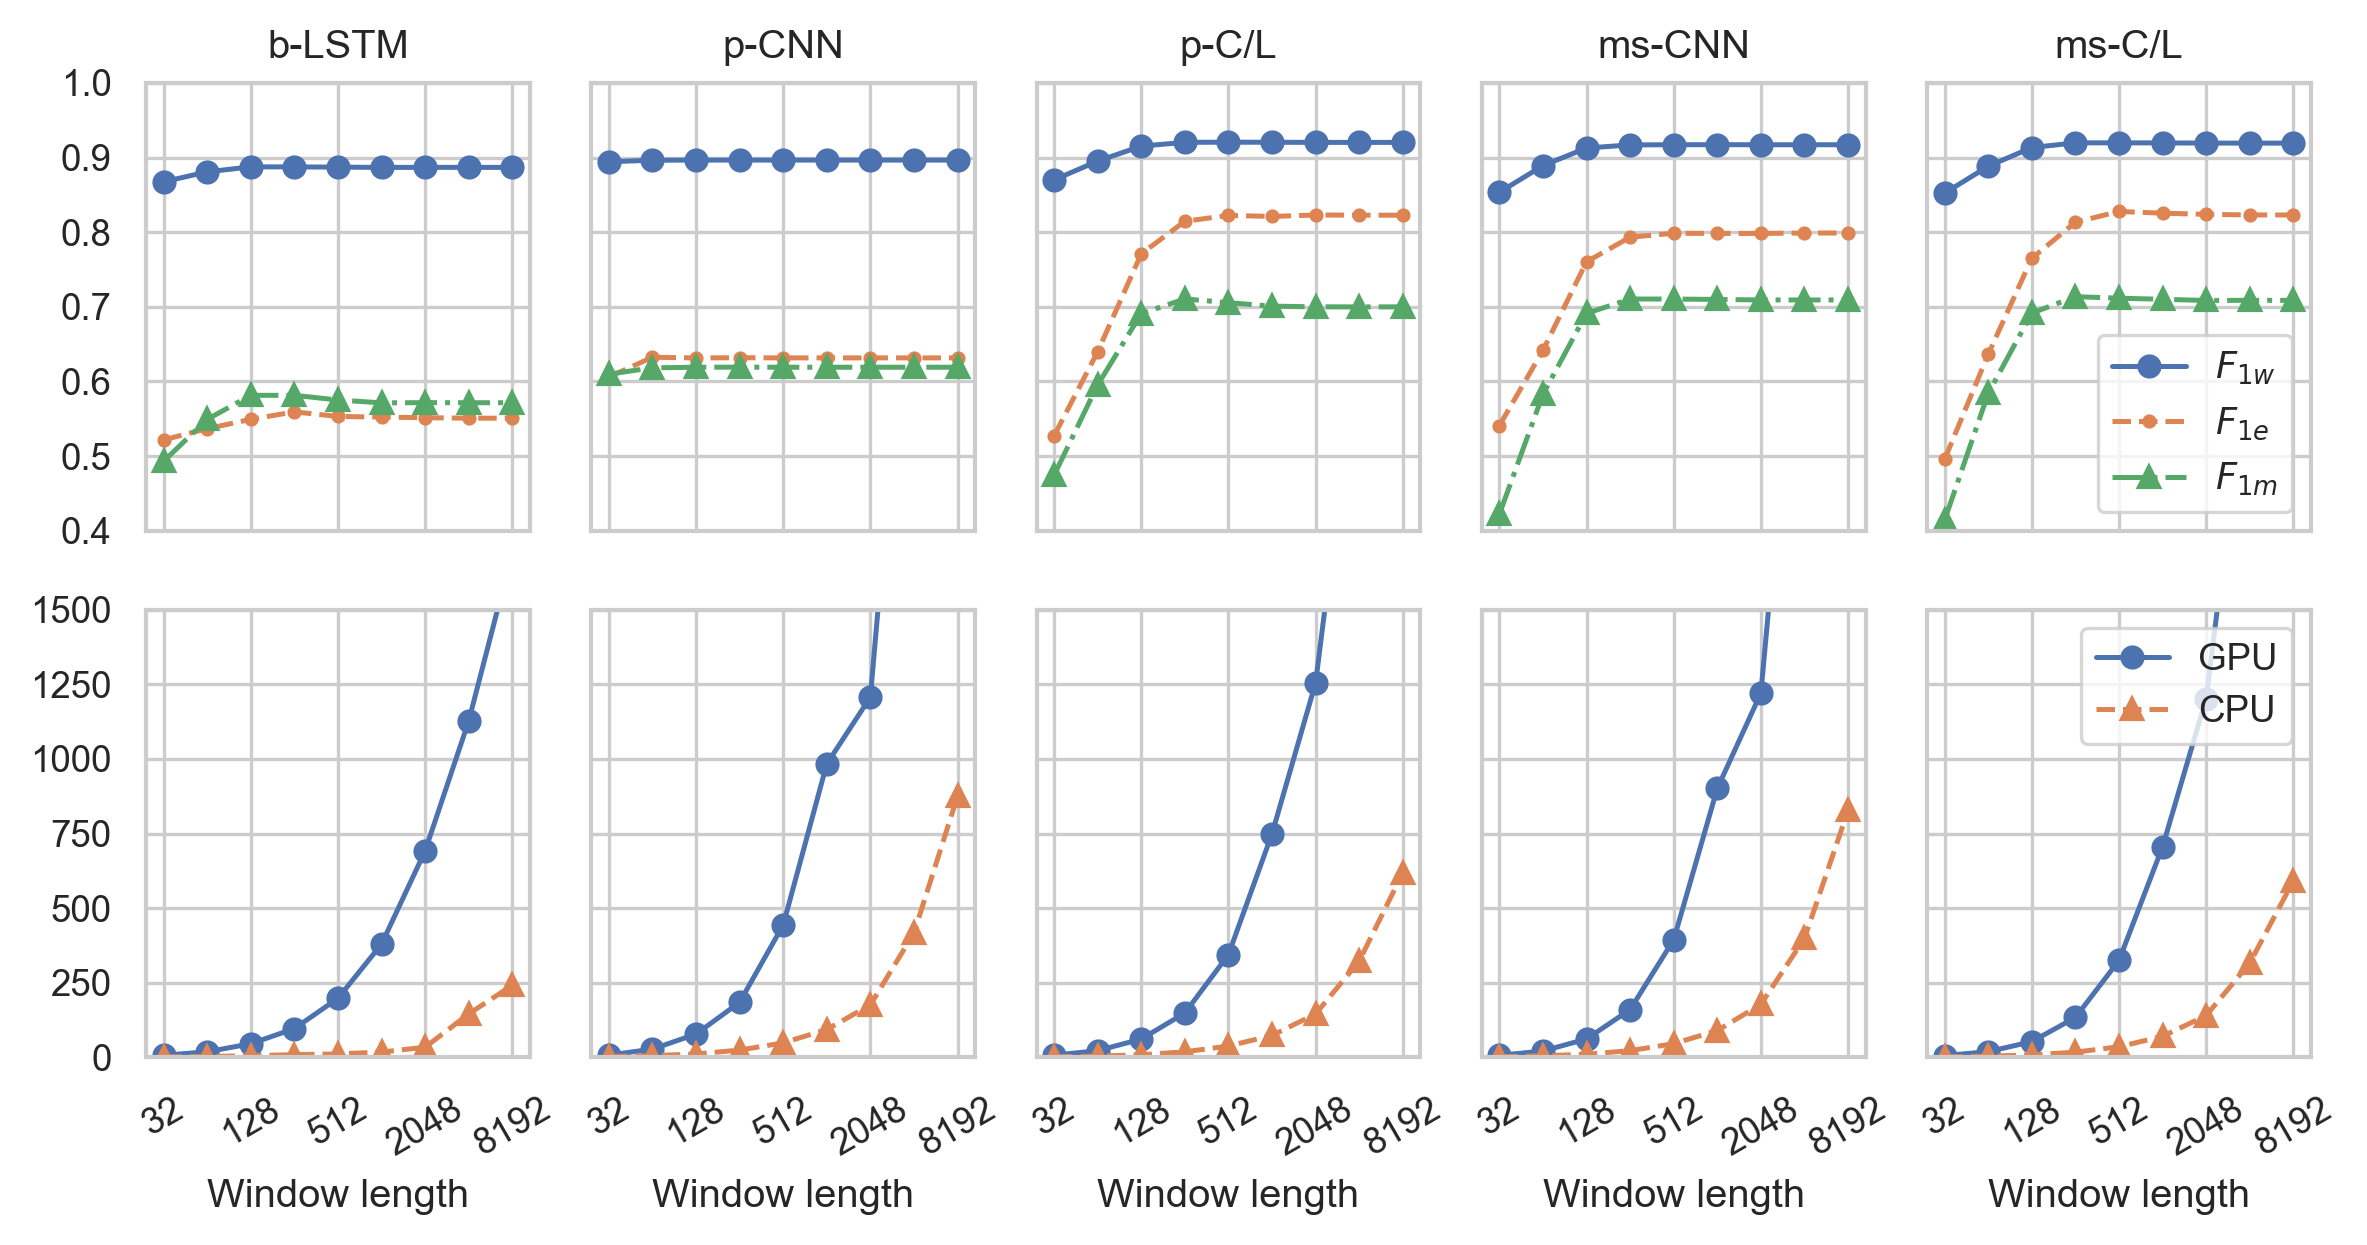

In [19]:
configs = [
    ['base_lstm'],
    ['base_cnn'],
    ['cnn_lstm'],
     ['multi_scale_cnn'], 
    ['multi_scale_cnn_lstm'],
]
names = [
    'b-LSTM',
    'p-CNN',
    'p-C/L',
    'ms-CNN',
    'ms-C/L'
]
def set_legend(legend_names, legend_title=None, ax=None):
    if ax is None:
        ax = gca()
    ax.get_legend().set_title(legend_title)
    # replace labels
    for t, l in zip(ax.get_legend().texts, legend_names): 
        t.set_text(l)

scale = .8
kwargs = dict( kind='point', dodge=True,
              ci="sd", capsize=.2, linestyles=['-', '--', '-.'], 
              markers = ['o', '.', '^'], scale=scale)

f, axes = subplots(2,len(configs), figsize=[1.6 * len(configs),4.25], dpi=300, sharex=True)
for i, (base_config,) in enumerate(configs):
    df5 = df2.loc[base_config].iloc[:-1,:]

    sca(axes[0][i])
    gca().set_xscale('log')
    
    plot(df5.index, df5.f1, 'o-', color=sns.palettes.color_palette()[0], label='$F_{1w}$')
    plot(df5.index, df5.event_f1, '.--', color=sns.palettes.color_palette()[1], label='$F_{1e}$')
    plot(df5.index, df5.f1_mean, '^-.', color=sns.palettes.color_palette()[2], label='$F_{1m}$')

    
#     ff = sns.pointplot(data=df3, x="win_len", y="value", hue='Metric',
#                        hue_order=["f1", "event_f1", "f1_mean"],
#                        **kwargs)

#     set_legend(['F1 (weighted)', 'F1 (mean)', 'Event F1'])

    title(names[i])
    ylim([.4, 1])
    xlabel(None)
    if i == len(configs)-1:
        ylabel('F1 metric value')
        legend(loc='lower right')
    
    gca().label_outer()
    
#     df3 =  pd.melt(df.query('base_config == @base_config'), id_vars=['base_config', 'win_len'], value_vars=['cuda_infer_rate', 'cpu_infer_rate'],
#                   var_name='Metric')
    sca(axes[1][i])
#     ff = sns.pointplot(data=df3, x="win_len", y="value", hue='Metric',**kwargs)
#     set_legend(['F1 (weighted)', 'Event F1'], #'Metric'
#         )
    plot(df5.index, df5.cuda_infer_rate, 'o-', color=sns.palettes.color_palette()[0], label='GPU')
    plot(df5.index, df5.cpu_infer_rate, '^--', color=sns.palettes.color_palette()[1], label='CPU')


    ylim([0, 1500])
#     xlim([0, None])

    xticks(df5.index[::2], [str(w) for w in df5.index[::2]], rotation=30)
    xlabel('Window length')
    if i == len(configs)-1:
        ylabel('Infer Rate [ksamp/s]')
        legend(loc='upper right')
        
    gca().label_outer()
    
    
tight_layout(w_pad=0.5)#w_pad=3)
plt.savefig('win_len_effects.png')

In [20]:
df5.iloc[0,0]

0.8522955341913907